<a href="https://colab.research.google.com/github/egynk3/simpleNeuralNetwork/blob/main/SimpleNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/60, Train Loss: 0.2306, Val Loss: 0.0738
Epoch 2/60, Train Loss: 0.0466, Val Loss: 0.0196
Epoch 3/60, Train Loss: 0.0140, Val Loss: 0.0083
Epoch 4/60, Train Loss: 0.0073, Val Loss: 0.0053
Epoch 5/60, Train Loss: 0.0052, Val Loss: 0.0042
Epoch 6/60, Train Loss: 0.0039, Val Loss: 0.0038
Epoch 7/60, Train Loss: 0.0032, Val Loss: 0.0026
Epoch 8/60, Train Loss: 0.0027, Val Loss: 0.0022
Epoch 9/60, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 10/60, Train Loss: 0.0018, Val Loss: 0.0015
Epoch 11/60, Train Loss: 0.0016, Val Loss: 0.0014
Epoch 12/60, Train Loss: 0.0015, Val Loss: 0.0013
Epoch 13/60, Train Loss: 0.0014, Val Loss: 0.0012
Epoch 14/60, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 15/60, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 16/60, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 17/60, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 18/60, Train Loss: 0.0010, Val Loss: 0.0010
Epoch 19/60, Train Loss: 0.0010, Val Loss: 0.0008
Epoch 20/60, Train Loss: 0.0010, Val Loss: 0.0008
Epoch 21/

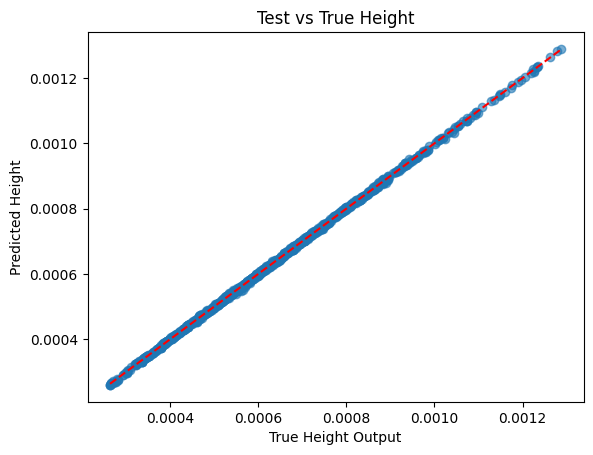

Experiment logged #


/tmp/ipython-input-3325988148.py:191: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  exp_log = pd.concat([exp_log, new_row], ignore_index=True)


In [1]:
#importing relevant libs
import numpy as np               # Numerical operations
import pandas as pd              # Data handling (e.g., read CSV files)
from sklearn.model_selection import train_test_split   # Split data into train/test
from sklearn.preprocessing import StandardScaler       # Normalize features
#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
#evaluation and vizualization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#importing data
url='https://github.com/egynk3/simpleNeuralNetwork/raw/main/Data/AllData.xlsx'
df = pd.read_excel(url)
# Experiment tracking
try:
    exp_log = pd.read_csv("experiment_log.csv")  # load existing log if available
except FileNotFoundError:
    exp_log = pd.DataFrame(columns=[
        "Experiment_ID", "Layers", "Neurons", "Dropout", "lr",
        "Weight_Decay", "Epochs", "Batch_Size",
        "Train_Loss", "Val_Loss", "Test_MSE", "Test_MAE", "Test_R2"
    ])

#normalize data:
#df mean=mean of each column in dataframe
#df-df.mean= subtract column mean from each value in column
#data now centered around zero
#df.std std of ech column as a series
#after, mean=zero and standard deviation of each col=1
#not normalizing outputs, axis=1 =cols
#splitting into features and targets

features = df.drop('h', axis=1)
target = df['h']
features_norm = (features - features.mean()) / features.std()
X=features_norm.values
y=target.values
#######################################################################
#splitting dataset into training set and temporary set(for val and test):
#.3=30% data goes into temp, 70% to train
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=33)
#splitting temporary into val and test set, 50/50 split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

########################################################
#scale inputs and outputs
#creation of scalar objects
scaler_X = StandardScaler()
scaler_y = StandardScaler()
#mean and std of each column, transform applies to all values
X_train_scaled = scaler_X.fit_transform(X_train)
#fit not called to avoid data leakage, scaled using training data mean and std
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
#reshaping to a 2d array
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

#currently all numpy arrays
########################################################


########################################################
##define network architecture
class outputHeight(nn.Module):
    def __init__(self, input_size):
        super(outputHeight, self).__init__()
        #layer definiton
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),#input to hidden layer
            nn.ReLU(), #activation
            nn.Linear(64,32), #hidden to hidden
            nn.ReLU(),
            nn.Linear(32,1) #hidden to output
        )
    def forward(self, x):
        return self.model(x)
#OPTIONAL         drop out + batch normalization for training stability

#instantiate model
input_dim = X_train_scaled.shape[1]
model = outputHeight(input_dim)

#define loss funciton
lossFunc = nn.MSELoss() #regression
#define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optional                             metric tracker r^2
#convertin numpy arrays to pytorch tensors
x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
#dataloader objects for batching
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
###round 2: epochs 100 -> 60
## Define experiment info

experiment_id = "round9"
layers = [32, 16]        # current architecture
neurons = [32, 16]       # redundant with layers, but keeps logging consistent
dropout = 0              # currently no dropout, can add later
lr = 0.0005
weight_decay = 0
epochs = 60
batch_size = 32
num_epochs = epochs
#feed training data into model
for epoch in range(num_epochs):
    model.train()#model in training mode
    train_loss= 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad() #clear prev gradients
        outputs = model(batch_x) #forward pass
        loss = lossFunc(outputs, batch_y) #compute loss
        loss.backward() #packpropagation
        optimizer.step() #updating weights
        train_loss += loss.item()*batch_x.size(0) #accumulating loss
    train_loss /= len(train_loader.dataset) #average loss over epoch

    #validation loop, monitering overfitting
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): #no gradients during validation
        val_outputs = model(x_val_tensor)
        val_loss = lossFunc(val_outputs, y_val_tensor).item()
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if epoch == 0:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    elif val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth') #save best model

#load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

#convert test numpy arrays to tensors
x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

#run predictions on test set
with torch.no_grad():
    y_pred_test_scaled = model(x_test_tensor)
    #INVERSE SCALING
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.numpy())
    y_true_test = scaler_y.inverse_transform(y_test_scaled)
    #evaluate performance
    mse = mean_squared_error(y_true_test, y_pred_test)
    mae = mean_absolute_error(y_true_test, y_pred_test)
    r2 = r2_score(y_true_test, y_pred_test)
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")
    #visualisation
    plt.scatter(y_true_test, y_pred_test, alpha=0.6)
    plt.xlabel('True Height Output')
    plt.ylabel('Predicted Height')
    plt.title('Test vs True Height')
    plt.plot([y_true_test.min(), y_true_test.max()],
             [y_true_test.min(), y_true_test.max()],
             'r--')
    plt.show()

# Log experiment results
new_row = pd.DataFrame([{
    "Experiment_ID": experiment_id,
    "Layers": layers,
    "Neurons": neurons,
    "Dropout": dropout,
    "lr": lr,
    "Weight_Decay": weight_decay,
    "Epochs": epochs,
    "Batch_Size": batch_size,
    "Train_Loss": train_loss,
    "Val_Loss": val_loss,
    "Test_MSE": mse,
    "Test_MAE": mae,
    "Test_R2": r2
}])

# Concatenate new row to the existing experiment log
exp_log = pd.concat([exp_log, new_row], ignore_index=True)

# Save updated log to CSV
exp_log.to_csv("experiment_log.csv", index=False)
print("Experiment logged #")



Refinement:
- reducing epochs from 100 to 60 as loss plateaus early
- making network smaller as dataset is small
- dropout layer to reduce overfitting
- weight decay in optimizer  
penalizes large weights in network to prevent overfitting so model can generalize to new data
- learning rate .001 to .0005  
size of each step when optimizer updates weights  
too high:overshooting   
too low: slow training, stuck in dips

**values to compare between experiments**
- training loss: how well model fits the traning data  
- value loss: how well the model generalizes to unseen validation data  
Goal to be low + close to eachother  
- if train<<value loss possible overfitting
- both high, underfitting  
**test metrics**
- mean squared error: overall prediction error
- mean absolute error: average magnitude of error, easier to interpret
- r2 how much variance the model explains, aim for 1  
**Hyperparameters**  
-layers/neurons: more improves capacity but increases risk of overfitting  
-dropout: reduces overfitting, compare with/without  
- lr:too high overshooting, too low: slow, stuck at minima  
- weight decay penalizes large weights in network to prevent overfitting so model can generalize to new data  
-epochs/batch size: affect convergence/stability
